### Import libraries


In [4]:
import os
import requests
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from datetime import datetime, timedelta
from IPython.display import clear_output

load_dotenv()

False

### Data expansion


Support functions


In [ ]:
def call_api_to_get_data(date, enddate, city = "Ho+Chi+Minh+City"):

    link = "http://api.worldweatheronline.com/premium/v1/past-weather.ashx?q={city}&date={date}&enddate={enddate}&key={api_key}&format=json&tp=1".format(
        date =date,
        enddate = enddate,
        city = city,
        api_key = "5a88568c19234641b9075742242403"
    )
    response = requests.get(link)
    return response.json()

def get_lst_first_day_last_day(start_date = datetime(2012, 10, 1), end_date = datetime(2017, 11, 30)):

    date_format = "%Y-%m-%d"

    current_date = start_date
    dates_list = []

    while current_date <= end_date:
        last_day_of_month = calendar.monthrange(current_date.year, current_date.month)[1]

        first_day_of_month = current_date.replace(day = 1)
        last_day_of_month = current_date.replace(day = last_day_of_month)

        dates_list.append((first_day_of_month.strftime(date_format), last_day_of_month.strftime(date_format)))

        current_date = last_day_of_month + timedelta(days=1)

    return dates_list

def handle_append_data(json, humidity_arr, time_arr, wind_dir_arr, wind_speed_arr, pressure_arr, weather_desc_arr , temp_arr):
    try:
        for day_data in json["data"]["weather"]:

            date = day_data["date"]
            for hour_data in day_data['hourly']:
                time = "{date} {time}:00:00".format(date = date, time = int(int(hour_data["time"])/100))
                wind_speed_ms = round(float(hour_data["windspeedKmph"])* (10/36),2)
                wind_dir = int(hour_data["winddirDegree"])
                humidity = int(hour_data["humidity"])
                pressure = int(hour_data["pressure"])
                tempK = int(hour_data["tempC"]) + 273.15
                weather_desc = hour_data["weatherDesc"][0]["value"]

                time_arr = np.append(time_arr, time)
                humidity_arr = np.append(humidity_arr ,  humidity)
                wind_speed_arr = np.append(wind_speed_arr, wind_speed_ms)
                wind_dir_arr = np.append(wind_dir_arr, wind_dir)
                pressure_arr = np.append(pressure_arr, pressure)
                temp_arr = np.append(temp_arr, tempK)
                weather_desc_arr = np.append(weather_desc_arr, weather_desc)
    except:
        print(json)

    return humidity_arr, time_arr, wind_dir_arr, wind_speed_arr, pressure_arr, weather_desc_arr , temp_arr

Read data into DataFrame


In [ ]:
df_humidity = pd.read_csv("dataset/humidity.csv")
df_pressure = pd.read_csv("dataset/pressure.csv")
df_temperature = pd.read_csv("dataset/temperature.csv")
df_weather_desc = pd.read_csv("dataset/weather_description.csv")
df_wind_dir = pd.read_csv("dataset/wind_direction.csv")
df_wind_speed = pd.read_csv("dataset/wind_speed.csv")

Crawl Ho Chi Minh city to merge old data


In [ ]:
humidity_arr = np.array([])
time_arr = np.array([])
wind_dir_arr = np.array([])
wind_speed_arr = np.array([])
pressure_arr = np.array([])
temp_arr = np.array([])
weather_desc_arr = np.array([], dtype = object)
count = 0
dates_list = get_lst_first_day_last_day()
for date in dates_list:
    clear_output(wait = True)
    print(count / len(dates_list) * 100)
    count += 1
    json = call_api_to_get_data(date[0], date[1])
    humidity_arr, time_arr, wind_dir_arr, wind_speed_arr, pressure_arr, weather_desc_arr , temp_arr = handle_append_data(
        json, humidity_arr, time_arr, wind_dir_arr, wind_speed_arr, pressure_arr, weather_desc_arr , temp_arr)

df_hcm_humidity = pd.DataFrame({"datetime": time_arr, "Ho Chi Minh City": humidity_arr})
df_hcm_pressure = pd.DataFrame({"datetime": time_arr, "Ho Chi Minh City": pressure_arr})
df_hcm_wind_dir = pd.DataFrame({"datetime": time_arr, "Ho Chi Minh City": wind_dir_arr})
df_hcm_wind_speed = pd.DataFrame({"datetime": time_arr, "Ho Chi Minh City": wind_speed_arr})
df_hcm_temp= pd.DataFrame({"datetime": time_arr, "Ho Chi Minh City": temp_arr})
df_hcm_weather_desc = pd.DataFrame({"datetime": time_arr, "Ho Chi Minh City": weather_desc_arr})

df_humidity = pd.merge(df_humidity, df_hcm_humidity, on = "datetime")
df_pressure = pd.merge(df_pressure, df_hcm_pressure, on = "datetime")
df_wind_dir = pd.merge(df_wind_dir, df_hcm_wind_dir, on = "datetime")
df_wind_speed = pd.merge(df_wind_speed, df_hcm_wind_speed, on = "datetime")
df_temperature = pd.merge(df_temperature, df_hcm_temp, on = "datetime")
df_weather_desc = pd.merge(df_weather_desc, df_hcm_weather_desc, on = "datetime")

In [ ]:
df_humidity.to_csv("historical-hourly-weather-dataset/humidity.csv", index = False)
df_pressure.to_csv("historical-hourly-weather-dataset/pressure.csv", index = False)
df_wind_dir.to_csv("historical-hourly-weather-dataset/wind_direction.csv", index = False)
df_wind_speed.to_csv("historical-hourly-weather-dataset/wind_speed.csv", index = False)
df_temperature.to_csv("historical-hourly-weather-dataset/temperature.csv", index = False)
df_weather_desc.to_csv("historical-hourly-weather-dataset/weather_description.csv", index = False)

In [ ]:
df_humidity=pd.read_csv("historical-hourly-weather-dataset/humidity.csv")
df_pressure=pd.read_csv("historical-hourly-weather-dataset/pressure.csv")
df_wind_dir=pd.read_csv("historical-hourly-weather-dataset/wind_direction.csv")
df_wind_speed=pd.read_csv("historical-hourly-weather-dataset/wind_speed.csv")
df_temperature=pd.read_csv("historical-hourly-weather-dataset/temperature.csv")
df_weather_desc=pd.read_csv("historical-hourly-weather-dataset/weather_description.csv")

Crawl data from 2023 to now


In [ ]:
df_country = pd.read_csv("dataset/city_attributes.csv")

lst_city = list(df_country.City.unique())
lst_city.append("Ho Chi Minh City")

size = len(lst_city)//3
part1 = lst_city[:size]
part2 = lst_city[size:2*size]
part3 = lst_city[2*size:]

In [ ]:
def process_city_data(lst_city):
    df_new_humidity = pd.DataFrame()
    df_new_pressure = pd.DataFrame()
    df_new_temperature = pd.DataFrame()
    df_new_weather_desc = pd.DataFrame()
    df_new_wind_dir = pd.DataFrame()
    df_new_wind_speed = pd.DataFrame()

    init = True

    for city in lst_city:
        lst_dates = get_lst_first_day_last_day(datetime(2023, 1, 1), datetime(2024, 3, 1))

        humidity_arr = np.array([])
        time_arr = np.array([])
        wind_dir_arr = np.array([])
        wind_speed_arr = np.array([])
        pressure_arr = np.array([])
        temp_arr = np.array([])
        weather_desc_arr = np.array([], dtype = object)
        count = 0
        for date in lst_dates:
            print(city, count/ len(lst_dates) * 100)
            count += 1
            json = call_api_to_get_data(date[0], date[1], city)
            humidity_arr, time_arr, wind_dir_arr, wind_speed_arr, pressure_arr, weather_desc_arr , temp_arr = handle_append_data(
                json, humidity_arr, time_arr, wind_dir_arr, wind_speed_arr, pressure_arr, weather_desc_arr , temp_arr)

        df_city_humidity = pd.DataFrame({"datetime": time_arr, city: humidity_arr})
        df_city_pressure = pd.DataFrame({"datetime": time_arr, city: pressure_arr})
        df_city_wind_dir = pd.DataFrame({"datetime": time_arr, city: wind_dir_arr})
        df_city_wind_speed = pd.DataFrame({"datetime": time_arr, city: wind_speed_arr})
        df_city_temp= pd.DataFrame({"datetime": time_arr, city: temp_arr})
        df_city_weather_desc = pd.DataFrame({"datetime": time_arr , city: weather_desc_arr})
        if init:
            df_new_humidity = df_city_humidity.copy()
            df_new_pressure = df_city_pressure.copy()
            df_new_wind_dir = df_city_wind_dir.copy()
            df_new_wind_speed = df_city_wind_speed.copy()
            df_new_temperature = df_city_temp.copy()
            df_new_weather_desc = df_city_weather_desc.copy()
            init = False
        else :
            df_new_humidity = pd.merge(df_new_humidity, df_city_humidity, on = "datetime")
            df_new_pressure = pd.merge(df_new_pressure, df_city_pressure, on = "datetime")
            df_new_wind_dir = pd.merge(df_new_wind_dir, df_city_wind_dir, on = "datetime")
            df_new_wind_speed = pd.merge(df_new_wind_speed, df_city_wind_speed, on = "datetime")
            df_new_temperature = pd.merge(df_new_temperature, df_city_temp, on = "datetime")
            df_new_weather_desc = pd.merge(df_new_weather_desc, df_city_weather_desc, on = "datetime")

    return df_new_humidity, df_new_pressure, df_new_temperature, df_new_weather_desc, df_new_wind_dir, df_new_wind_speed



In [ ]:
df_new_humidity1, df_new_pressure1, df_new_temperature1, df_new_weather_desc1, df_new_wind_dir1, df_new_wind_speed1 = process_city_data(part1)

In [ ]:
df_new_humidity2, df_new_pressure2, df_new_temperature2, df_new_weather_desc2, df_new_wind_dir2, df_new_wind_speed2 = process_city_data(part2)

In [ ]:
df_new_humidity3, df_new_pressure3, df_new_temperature3, df_new_weather_desc3, df_new_wind_dir3, df_new_wind_speed3 = process_city_data(part3)

In [ ]:
df_new_humidity_4 = pd.merge(df_new_humidity1, df_new_humidity2, on="datetime")
df_new_humidity_4 = pd.merge(df_new_humidity_4, df_new_humidity3, on="datetime")

df_new_pressure_4 = pd.merge(df_new_pressure1, df_new_pressure2, on="datetime")
df_new_pressure_4 = pd.merge(df_new_pressure_4, df_new_pressure3, on="datetime")

df_new_temperature_4 = pd.merge(df_new_temperature1, df_new_temperature2, on="datetime")
df_new_temperature_4 = pd.merge(df_new_temperature_4, df_new_temperature3, on="datetime")

df_new_weather_desc_4 = pd.merge(df_new_weather_desc1, df_new_weather_desc2, on="datetime")
df_new_weather_desc_4 = pd.merge(df_new_weather_desc_4, df_new_weather_desc3, on="datetime")

df_new_wind_dir_4 = pd.merge(df_new_wind_dir1, df_new_wind_dir2, on="datetime")
df_new_wind_dir_4 = pd.merge(df_new_wind_dir_4, df_new_wind_dir3, on="datetime")

df_new_wind_speed_4 = pd.merge(df_new_wind_speed1, df_new_wind_speed2, on="datetime")
df_new_wind_speed_4 = pd.merge(df_new_wind_speed_4, df_new_wind_speed3, on="datetime")



Merge into one DataFrame per attribute


In [ ]:
df_humidity = pd.concat([df_humidity, df_new_humidity_4], axis = 0)
df_pressure = pd.concat([df_pressure, df_new_pressure_4], axis = 0)
df_wind_dir = pd.concat([df_wind_dir, df_new_wind_dir_4], axis = 0)
df_wind_speed = pd.concat([df_wind_speed, df_new_wind_speed_4], axis = 0)
df_temperature = pd.concat([df_temperature, df_new_temperature_4], axis = 0)
df_weather_desc = pd.concat([df_weather_desc, df_new_weather_desc_4], axis = 0)

Save to .csv files


In [ ]:
df_humidity.to_csv("merged_data/humidity.csv", index = False)
df_pressure.to_csv("merged_data/pressure.csv", index = False)
df_wind_dir.to_csv("merged_data/wind_direction.csv", index = False)
df_wind_speed.to_csv("merged_data/wind_speed.csv", index = False)
df_temperature.to_csv("merged_data/temperature.csv", index = False)
df_weather_desc.to_csv("merged_data/weather_description.csv", index = False)

In [ ]:
def plot_weather_data(weather_df,city_name,years):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates

    df_draw = weather_df[weather_df['datetime'].dt.year == years]

    fig, ax = plt.subplots()

    ax.plot(df_draw['datetime'], df_draw[city_name])

    ax.xaxis.set_major_locator(mdates.DayLocator(interval=70))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.figure()
    
    plt.show()

    

In [ ]:
df_humidity['datetime'] = pd.to_datetime(df_humidity['datetime'])
df_pressure['datetime'] = pd.to_datetime(df_pressure['datetime'])
df_wind_dir['datetime'] = pd.to_datetime(df_wind_dir['datetime'])
df_wind_speed['datetime'] = pd.to_datetime(df_wind_speed['datetime'])
df_temperature['datetime'] = pd.to_datetime(df_temperature['datetime'])

In [ ]:
plot_weather_data(df_humidity, 'Ho Chi Minh City',2023)

### Data cleaning & integration


In [1]:
import os
os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'

In [2]:
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from datetime import datetime, timedelta
from IPython.display import clear_output
import pyspark.pandas as ps
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("App Name") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.autoBroadcastJoinThreshold", "-1") \
    .getOrCreate()


Load data


In [4]:
weather_conditions_df = ps.read_csv('merged_data/weather_description.csv')
humidity_df = ps.read_csv('merged_data/humidity.csv')
pressure_df = ps.read_csv('merged_data/pressure.csv')
temperature_df = ps.read_csv('merged_data/temperature.csv')
wind_direction_df = ps.read_csv('merged_data/wind_direction.csv')
wind_speed_df = ps.read_csv('merged_data/wind_speed.csv')
city_attributes_df = ps.read_csv('merged_data/city_attributes.csv')

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [5]:
DATETIME_COL = 'datetime'
HUMIDITY_COL = 'humidity'
PRESSURE_COL = 'pressure'
TEMPERATURE_COL = 'temperature'
WIND_DIRECTION_COL = 'wind_direction'
WIND_SPEED_COL = 'wind_speed'
LATITUDE_COL = 'latitude'
LONGITUDE_COL = 'longitude'
CITY_COL = 'city'
COUNTRY_COL = 'country'
WEATHER_CONDITION_COL = 'weather_condition'

Create a single `DataFrame` that includes all data from the others


In [6]:
def filter_dataframe_by_city_column(dataframe, city_name, new_column_name):
    return dataframe.to_spark() \
        .withColumn(new_column_name, col(city_name)) \
        .select([DATETIME_COL, new_column_name])
        

def join_dataframes(dataframes: List[DataFrame], column_name: str) -> DataFrame:
    joined_df = dataframes[0]

    for dataframe in dataframes[1:]:
        joined_df = joined_df.join(dataframe, [column_name])

    return joined_df

In [7]:
weather_measurements_df = None

# Iterate over all the records in the cities `DataFrame`
for index, row in city_attributes_df.iterrows():    

    city = row.City
    country = row.Country
    latitude = row.Latitude
    longitude = row.Longitude

    # Compute a list of `DataFrame`, one for each type of measurement in the city
    dataframes = [
        filter_dataframe_by_city_column(humidity_df, city, HUMIDITY_COL),
        filter_dataframe_by_city_column(pressure_df, city, PRESSURE_COL),
        filter_dataframe_by_city_column(temperature_df, city, TEMPERATURE_COL),
        filter_dataframe_by_city_column(wind_direction_df, city, WIND_DIRECTION_COL),
        filter_dataframe_by_city_column(wind_speed_df, city, WIND_SPEED_COL),
        filter_dataframe_by_city_column(weather_conditions_df, city, WEATHER_CONDITION_COL)
    ]

    # Compute a `DataFrame` that includes all the data about the measurements in the city
    joined_df = join_dataframes(dataframes, DATETIME_COL) \
        .withColumn(CITY_COL, lit(city)) \
        .withColumn(COUNTRY_COL, lit(country)) \
        .withColumn(LATITUDE_COL, lit(latitude)) \
        .withColumn(LONGITUDE_COL, lit(longitude))

    # Union the `DataFrame` with the ones computed in the previous iterations
    weather_measurements_df = weather_measurements_df.union(joined_df) if weather_measurements_df is not None else joined_df

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [7]:
weather_measurements_df.head(5)

Clean missing value


In [8]:
not_null_weather_measurements_df = weather_measurements_df.dropna()

In [9]:
not_null_weather_measurements_df.head(5)

In [9]:
not_null_weather_measurements_df.toPandas().to_csv('weather_measurements.csv', index=False)

### Label aggregation


In [10]:
def get_weather_conditions_aggregation_dict(weather_conditions):
    weather_conditions_dict = dict()
  
    for weather_condition in weather_conditions:
  
        weather_condition_lowered = weather_condition.lower()

        if any(key in weather_condition_lowered for key in ['squall', 'thunderstorm']):
            weather_conditions_dict[weather_condition] = 'thunderstorm'
        elif any(key in weather_condition_lowered for key in ['drizzle', 'rain']):
            weather_conditions_dict[weather_condition] = 'rainy'
        elif any(key in weather_condition_lowered for key in ['sleet', 'snow']):
            weather_conditions_dict[weather_condition] = 'snowy'
        elif any(key in weather_condition_lowered for key in ['smoke', 'cloud']):
            weather_conditions_dict[weather_condition] = 'cloudy'
        elif any(key in weather_condition_lowered for key in ['fog', 'mist', 'haze']):
            weather_conditions_dict[weather_condition] = 'foggy'
        elif any(key in weather_condition_lowered for key in ['clear', 'sun']):
            weather_conditions_dict[weather_condition] = 'sunny'
            
    return weather_conditions_dict

In [11]:
weather_conditions_all = not_null_weather_measurements_df \
    .select(col(WEATHER_CONDITION_COL)).distinct() \
    .toPandas()[WEATHER_CONDITION_COL].to_numpy().reshape(-1)

In [12]:
weather_conditions_dict = get_weather_conditions_aggregation_dict(weather_conditions_all)

Replace all the weather conditions in the `DataFrame` with the aggregated ones


In [13]:
weather_measurements_aggregated_df = not_null_weather_measurements_df.replace(weather_conditions_dict)

In [21]:
weather_measurements_aggregated_df.count()

1258393

Remove all samples that contain other conditions


In [22]:
WEATHER_CONDITIONS = set(weather_conditions_dict.values())

weather_measurements_aggregated_df = weather_measurements_aggregated_df \
    .filter(weather_measurements_aggregated_df[WEATHER_CONDITION_COL].isin(WEATHER_CONDITIONS))

In [23]:
# Get all unique value from weather_measurements_aggregated_df in column weather_condition
weather_conditions = weather_measurements_aggregated_df \
    .select(col(WEATHER_CONDITION_COL)).distinct() \
    .toPandas()[WEATHER_CONDITION_COL].to_numpy().reshape(-1)
    
print(weather_conditions)

['rainy' 'snowy' 'sunny' 'cloudy' 'thunderstorm' 'foggy']


### Undersampling


In [35]:
weather_condition_distribution = weather_measurements_aggregated_df.groupBy(WEATHER_CONDITION_COL).count()

# Hiển thị kết quả
weather_condition_distribution.show()

+-----------------+------+
|weather_condition| count|
+-----------------+------+
|            rainy|177630|
|            snowy| 18357|
|            sunny|545738|
|           cloudy|419296|
|     thunderstorm|  6438|
|            foggy| 90934|
+-----------------+------+



In [30]:
def count_weather_condition_occurrences(dataframe: DataFrame, class_name: str) -> int:
    return dataframe.filter(dataframe[WEATHER_CONDITION_COL] == class_name).count()

def get_undersampling_fracs(dataframe: DataFrame) -> Dict[str, float]:
    counts = {class_name: count_weather_condition_occurrences(dataframe, class_name) 
              for class_name in ['rainy', 'snowy', 'sunny', 'foggy', 'cloudy', 'thunderstorm']}
    
    # Loại bỏ các lớp không có mẫu
    counts = {class_name: count for class_name, count in counts.items() if count > 0}
    
    if len(counts) == 0:
        return {}
    
    minority_class_cnt = np.min(list(counts.values()))

    return {class_name: minority_class_cnt / count for class_name, count in counts.items()}



In [36]:
sampled_weather_measurements_df = weather_measurements_aggregated_df.sampleBy(
    WEATHER_CONDITION_COL,
    fractions = get_undersampling_fracs(weather_measurements_aggregated_df),
    seed = 42)

In [37]:
sampled_weather_measurements_df.count()

38837

Save the undersampled dataset


In [16]:
sampled_weather_measurements_df.toPandas().to_csv('sampled_weather.csv', index=False)

### Data statistics


Load data


In [39]:

data = ps.read_csv('sampled_dataset/sampled_weather.csv')

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [40]:
features = [
    'humidity',
    'pressure',
    'temperature',
    'wind_direction',
    'wind_speed',
    'latitude',
    'longitude',
]

In [41]:
len(data)

38837

In [42]:
data.head()

,datetime,humidity,pressure,temperature,wind_direction,wind_speed,weather_condition,city,country,latitude,longitude
0,2012-10-16 22:00:00,93.0,993.0,285.20,40.0,2.0,rainy,Vancouver,Canada,49.24966,-123.119339
1,2012-11-01 12:00:00,93.0,1006.0,283.43,110.0,4.0,sunny,Vancouver,Canada,49.24966,-123.119339
2,2012-11-06 21:00:00,87.0,1028.0,284.21,270.0,2.0,sunny,Vancouver,Canada,49.24966,-123.119339
3,2012-11-13 16:00:00,93.0,1019.0,278.16,90.0,5.0,sunny,Vancouver,Canada,49.24966,-123.119339
4,2012-11-23 20:00:00,74.0,1016.0,279.65,20.0,2.0,snowy,Vancouver,Canada,49.24966,-123.119339


Descriptive statistics


In [43]:
data[features].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
humidity,38837.0,72.497798,20.956649,5.000000,60.000000,77.000000,89.000000,100.000000
pressure,38837.0,1016.593686,11.898882,804.000000,1012.000000,1016.000000,1022.000000,1100.000000
temperature,38837.0,286.983660,12.095432,248.150000,277.150000,288.370000,296.776333,319.150000
wind_direction,38837.0,183.536190,104.197183,0.000000,96.000000,190.000000,270.000000,360.000000
wind_speed,38837.0,3.320428,2.280386,0.000000,1.940000,3.000000,4.720000,21.000000
latitude,38837.0,37.863317,5.944659,25.774269,32.815559,39.099731,42.331429,49.249660
longitude,38837.0,-81.844830,39.402933,-123.119339,-98.493629,-86.158043,-79.416298,35.216331


In [45]:
import matplotlib.pyplot as plt

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\pandas\base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_list` loads all data into the driver's memory. It should only be used if the resulting list is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\pandas\generic.py:647: UserWarning: We recommend using `Series.to_numpy()` instead.
  warnings.warn("We recommend using `{}.to_numpy()` instead.".format(type(self).__name__))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy 

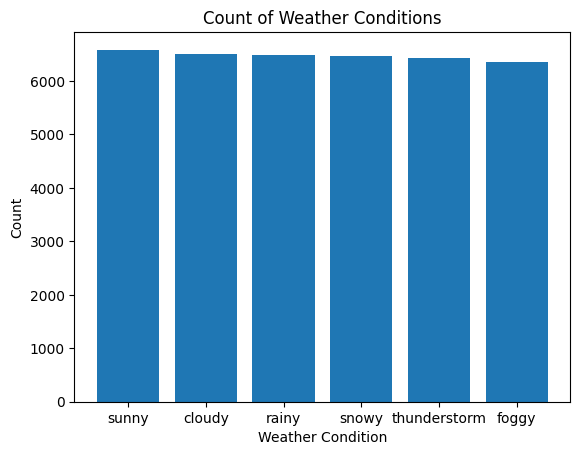

In [49]:
counts = data['weather_condition'].value_counts()
plt.bar(counts.index.tolist(), counts.values)
plt.xlabel('Weather Condition')
plt.ylabel('Count')
plt.title('Count of Weather Conditions')
plt.show()



Boxplot


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


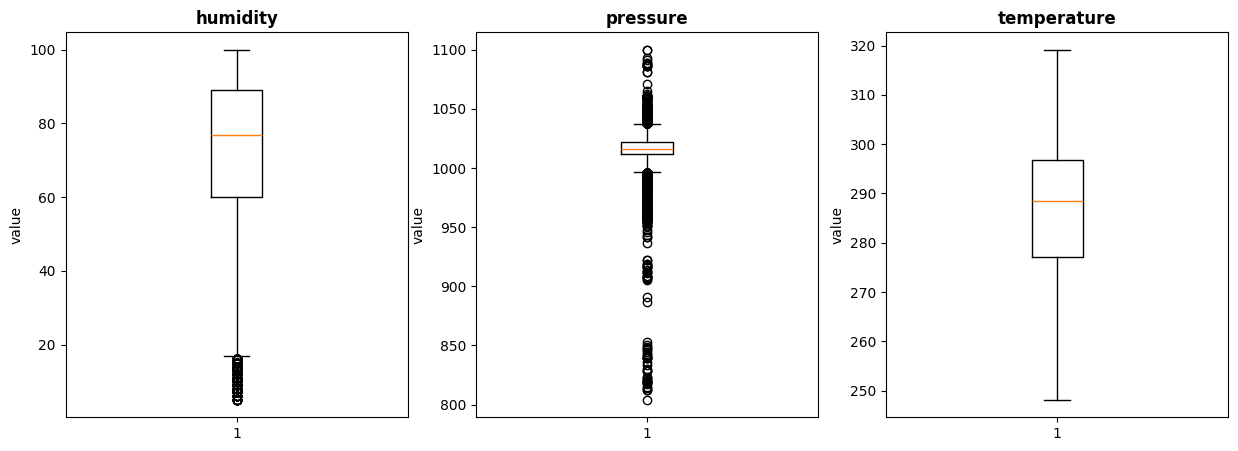

In [50]:
features = ['humidity', 'pressure', 'temperature']

# Plot the data
fig, axs = plt.subplots(1, 3, figsize = (15, 5))

axs[0].boxplot(data[features[0]])
axs[0].set_ylabel('value')
axs[0].set_title(features[0], fontweight = "bold")

axs[1].boxplot(data[features[1]])
axs[1].set_ylabel('value')
axs[1].set_title(features[1], fontweight = "bold")

axs[2].boxplot(data[features[2]])
axs[2].set_ylabel('value')
axs[2].set_title(features[2], fontweight = "bold")

plt.show()

Distribution


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_list` loads all data into the driver's memory. It should only be used if the resulting list is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


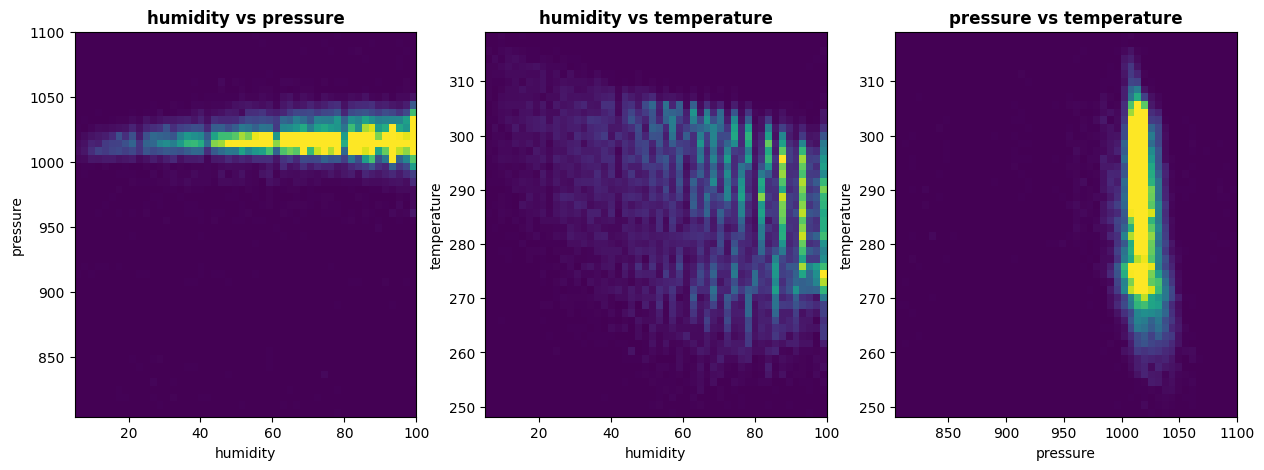

In [51]:
features = ['humidity', 'pressure', 'temperature']
f1_list = data[features[0]].tolist()
f2_list = data[features[1]].tolist()
f3_list = data[features[2]].tolist()

# Plot the data
fig, axs = plt.subplots(1, 3, figsize = (15, 5))

axs[0].hist2d(f1_list, f2_list, bins = (50, 50), vmax = 200)
axs[0].set_xlabel(features[0])
axs[0].set_ylabel(features[1])
axs[0].set_title(features[0] + ' vs ' + features[1], fontweight = "bold")

axs[1].hist2d(f1_list, f3_list, bins = (50, 50), vmax = 200)
axs[1].set_xlabel(features[0])
axs[1].set_ylabel(features[2])
axs[1].set_title(features[0] + ' vs ' + features[2], fontweight = "bold")

axs[2].hist2d(f2_list, f3_list, bins = (50, 50), vmax = 200)
axs[2].set_xlabel(features[1])
axs[2].set_ylabel(features[2])
axs[2].set_title(features[1] + ' vs ' + features[2], fontweight = "bold")

plt.show()

# Machine Learning pipeline


### Import libraries


In [1]:
import os
os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'

In [2]:
import requests
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

import findspark
findspark.init()
findspark.find() 

import pyspark.pandas as ps
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler, IndexToString
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, DecisionTreeClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [3]:
data = ps.read_csv('sampled_dataset/sampled_weather.csv')

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


### Pre-processing


Select relevant features and label column


In [4]:
# Select relevant features
numerical_cols = [
    'humidity',
    'pressure',
    'temperature',
    'wind_direction',
    'wind_speed',
    'latitude',
    'longitude'
]
nominal_cols = []
# Select the label column
label_col = 'weather_condition'
prediction_col = 'predicted_weather_condition'
# Select the features and the label
df_selected = data[numerical_cols + nominal_cols + [label_col]]

In [5]:
df_selected.head()

,humidity,pressure,temperature,wind_direction,wind_speed,latitude,longitude,weather_condition
0,93.0,993.0,285.20,40.0,2.0,49.24966,-123.119339,rainy
1,93.0,1006.0,283.43,110.0,4.0,49.24966,-123.119339,sunny
2,87.0,1028.0,284.21,270.0,2.0,49.24966,-123.119339,sunny
3,93.0,1019.0,278.16,90.0,5.0,49.24966,-123.119339,sunny
4,74.0,1016.0,279.65,20.0,2.0,49.24966,-123.119339,snowy


In [6]:
len(df_selected)

38837

In [8]:
# Convert the DataFrame to a Spark DataFrame
df_selected = df_selected.to_spark()

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Train-Test split


In [9]:
train_data, test_data = df_selected.randomSplit([0.8, 0.2], seed = 42)

In [11]:
print(f'Train set size:  {train_data.count()} instances')
print(f'Test set size:   {test_data.count()} instances')
     

Train set size:  31079 instances
Test set size:   7758 instances


Encode


In [12]:
def encode(
    df,
    numerical_cols = [],
    nominal_cols = [],
    label_col = '',
    with_std = True,
    with_mean = True,
):
    # Convert categorical label to numerical label
    label_indexer = StringIndexer(
        inputCol = label_col,
        outputCol = 'label',
        handleInvalid = 'keep'
    )
    
    # Assemble features into a vector
    feature_cols = numerical_cols + nominal_cols
    vector_assembler = VectorAssembler(
        inputCols = feature_cols,
        outputCol = 'raw_features'
    )
    
    # Scale the features
    scaler = StandardScaler(
        inputCol = 'raw_features',
        outputCol = 'scaled_features',
        withStd = with_std,
        withMean = with_mean
    )
    
    stages = [label_indexer, vector_assembler, scaler]
    pipeline = Pipeline(stages = stages)
    
    transformer = pipeline.fit(df)
    
    return transformer

In [13]:
data_encoder = encode(
    df = df_selected,
    numerical_cols = numerical_cols,
    nominal_cols = nominal_cols,
    label_col = label_col
)

# Weather Forecasting models


In [14]:
"""
    Support functions for training and evaluating the model
"""

# Evaluate the model
def evaluate(predictions):
    accuracy = MulticlassClassificationEvaluator(
        labelCol = 'label',
        predictionCol = 'prediction',
        metricName = 'accuracy'
    )
    precision = MulticlassClassificationEvaluator(
        labelCol = 'label',
        predictionCol = 'prediction',
        metricName = 'weightedPrecision'
    )
    recall = MulticlassClassificationEvaluator(
        labelCol = 'label',
        predictionCol = 'prediction',
        metricName = 'weightedRecall'
    )
    f1 = MulticlassClassificationEvaluator(
        labelCol = 'label',
        predictionCol = 'prediction',
        metricName = 'f1'
    )
    
    print('Accuracy:', accuracy.evaluate(predictions))
    print('Precision:', precision.evaluate(predictions))
    print('Recall:', recall.evaluate(predictions))
    print('F1:', f1.evaluate(predictions))
    
# Confusion matrix
def plot_confusion_matrix(predictions_df, normalize: bool = False, title: str = None): 
    labels = predictions_df.select(label_col).to_koalas().to_numpy()
    pedictions = predictions_df.select(prediction_col).to_koalas().to_numpy()

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(labels, pedictions, labels=None)
    
    # Only use the labels that appear in the data
    classes = unique_labels(labels, pedictions)

    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,           
           xlabel='Predicted label', ylabel='True label',
           title=title)

    ax.set_ylim(len(classes) - 0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation = 45, ha = 'right', rotation_mode = 'anchor')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, format(cm[i, j], fmt), ha = 'center', va = 'center',
                color = 'white' if cm[i, j] > thresh else 'black'
            )

    fig.tight_layout()
    plt.show()
    
# Index to string
idx_to_str = IndexToString(
    inputCol = 'prediction',
    outputCol = prediction_col,
    labels = data_encoder.stages[0].labels
)

### Random Forest


Define the classifier


In [20]:
classifier = RandomForestClassifier(
    featuresCol = 'scaled_features',
    labelCol = 'label',
    numTrees = 10,
    maxDepth = 8,
)

Define the pipeline with the encoding and classifier stages


In [21]:
pipeline = Pipeline(stages = [data_encoder, classifier])

Define the evaluator


In [22]:
evaluator = MulticlassClassificationEvaluator(
    labelCol = 'label',
    predictionCol = 'prediction',
    metricName = 'accuracy'
)

Define hyperparameter tuning (optional)


In [23]:
# Define the grid of hyperparameters
param_grid = ParamGridBuilder().build()

# Set up the cross validator for model training and hyperparameter tuning
cross_validator = CrossValidator(
    estimator = pipeline,
    estimatorParamMaps = param_grid,
    evaluator = evaluator,
    numFolds = 5
)

Fit the model using the training data


In [24]:
model = cross_validator.fit(train_data)

Predict and evaluate on test data


In [25]:
predictions = model.transform(test_data)

In [26]:
evaluate(predictions)

Accuracy: 0.5510440835266821
Precision: 0.5288763946129775
Recall: 0.5510440835266822
F1: 0.5268924552800087


In [27]:
predictions = idx_to_str.transform(predictions)

Confusion matrix


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


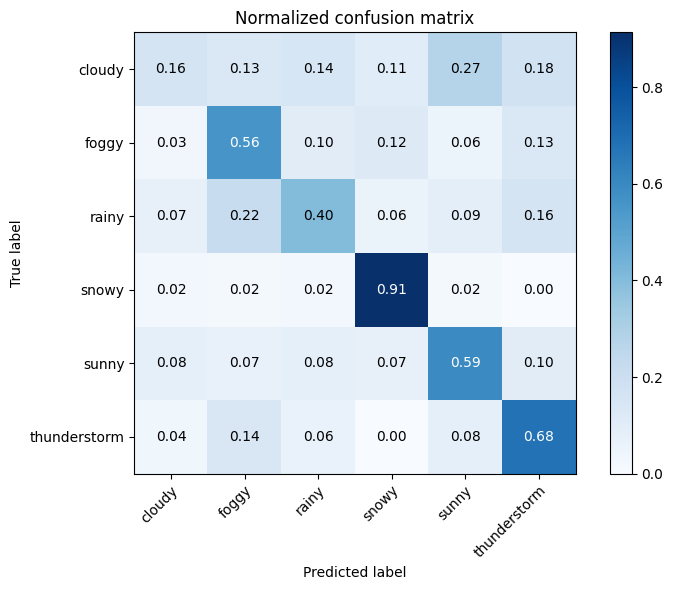

In [28]:
plot_confusion_matrix(predictions, normalize = True)

### Logistic Regression


Define the classifier


In [29]:
classifier = LogisticRegression(
    featuresCol = 'scaled_features',
    labelCol = 'label',
    maxIter = 1000,
    regParam = 0.0,
    elasticNetParam = 0.0
)

Define the pipeline with the encoding and classifier stages


In [30]:
pipeline = Pipeline(stages = [data_encoder, classifier])

Define the evaluator


In [31]:
evaluator = MulticlassClassificationEvaluator(
    labelCol = 'label',
    predictionCol = 'prediction',
    metricName = 'accuracy'
)

Define hyperparameter tuning (optional)


In [32]:
# Define the grid of hyperparameters
param_grid = ParamGridBuilder().build()

# Set up the cross validator for model training and hyperparameter tuning
cross_validator = CrossValidator(
    estimator = pipeline,
    estimatorParamMaps = param_grid,
    evaluator = evaluator,
    numFolds = 5
)

Fit the model using the training data


In [33]:
model = cross_validator.fit(train_data)

Predict and evaluate on test data


In [34]:
predictions = model.transform(test_data)

In [35]:
evaluate(predictions)

Accuracy: 0.4911059551430781
Precision: 0.4630413589091454
Recall: 0.4911059551430781
F1: 0.46196841834251684


In [36]:
predictions = idx_to_str.transform(predictions)

Confusion matrix


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


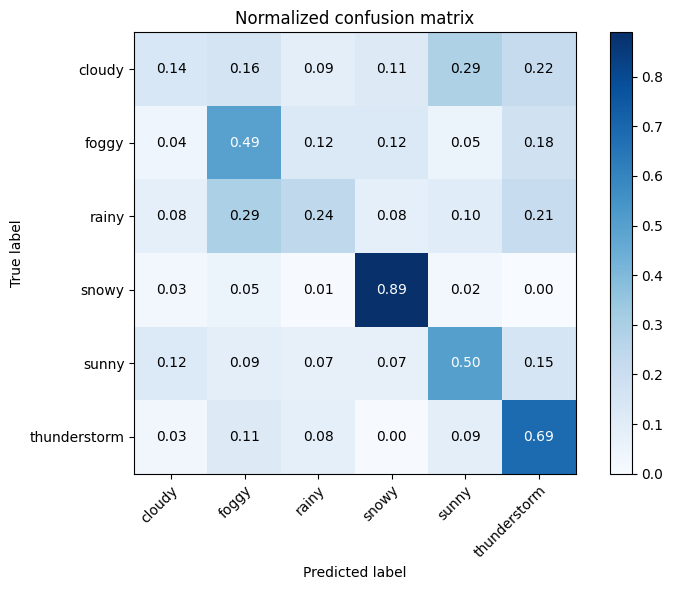

In [37]:
plot_confusion_matrix(predictions, normalize = True)

### Decision Tree


Define the classifier


In [50]:
classifier = DecisionTreeClassifier(
    featuresCol = 'scaled_features',
    labelCol = 'label',
    maxDepth = 30
)

Define the pipeline with the encoding and classifier stages


In [51]:
pipeline = Pipeline(stages = [data_encoder, classifier])

Define the evaluator


In [52]:
evaluator = MulticlassClassificationEvaluator(
    labelCol = 'label',
    predictionCol = 'prediction',
    metricName = 'accuracy'
)

Define hyperparameter tuning (optional)


In [53]:
# Define the grid of hyperparameters
param_grid = ParamGridBuilder().build()

# Set up the cross validator for model training and hyperparameter tuning
cross_validator = CrossValidator(
    estimator = pipeline,
    estimatorParamMaps = param_grid,
    evaluator = evaluator,
    numFolds = 5
)

Fit the model using the training data


In [54]:
model = cross_validator.fit(train_data)

Predict and evaluate on test data


In [48]:
predictions = model.transform(test_data)

In [49]:
evaluate(predictions)

Accuracy: 0.4769270430523331
Precision: 0.47701854910829
Recall: 0.4769270430523331
F1: 0.4768991156646315


In [55]:
predictions = idx_to_str.transform(predictions)

Confusion matrix


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


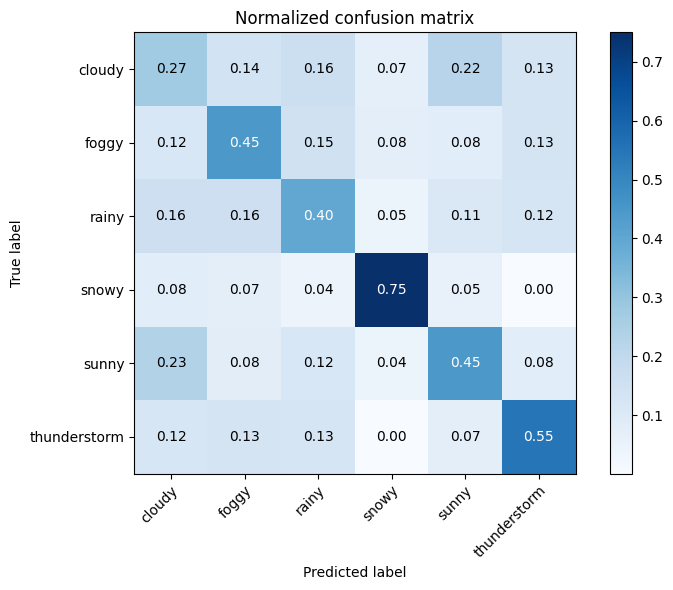

In [56]:
plot_confusion_matrix(predictions, normalize = True)

### Multilayer Perceptron


Define the layers of the neural network


In [57]:
layers = [len(numerical_cols) + len(nominal_cols), 32, 64, 128, 6]

Define the classifier


In [58]:
classifier = MultilayerPerceptronClassifier(
    featuresCol = 'scaled_features',
    labelCol = 'label',
    maxIter = 500,
    layers = layers,
    blockSize = 128,
    seed = 42,
)

Define the pipeline with the encoding and classifier stages


In [59]:
pipeline = Pipeline(stages = [data_encoder, classifier])

Define the evaluator


In [60]:
evaluator = MulticlassClassificationEvaluator(
    labelCol = 'label',
    predictionCol = 'prediction',
    metricName = 'accuracy'
)

Define hyperparameter tuning (optional)


In [61]:
# Define the grid of hyperparameters
param_grid = ParamGridBuilder().build()

# Set up the cross validator for model training and hyperparameter tuning
cross_validator = CrossValidator(
    estimator = pipeline,
    estimatorParamMaps = param_grid,
    evaluator = evaluator,
    numFolds = 5
)

Fit the model using the training data


In [62]:
model = cross_validator.fit(train_data)

Predict and evaluate on test data


In [63]:
predictions = model.transform(test_data)

In [64]:
evaluate(predictions)

Accuracy: 0.5556844547563805
Precision: 0.531033459859279
Recall: 0.5556844547563806
F1: 0.5331126807719409


In [65]:
predictions = idx_to_str.transform(predictions)

Confusion matrix


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


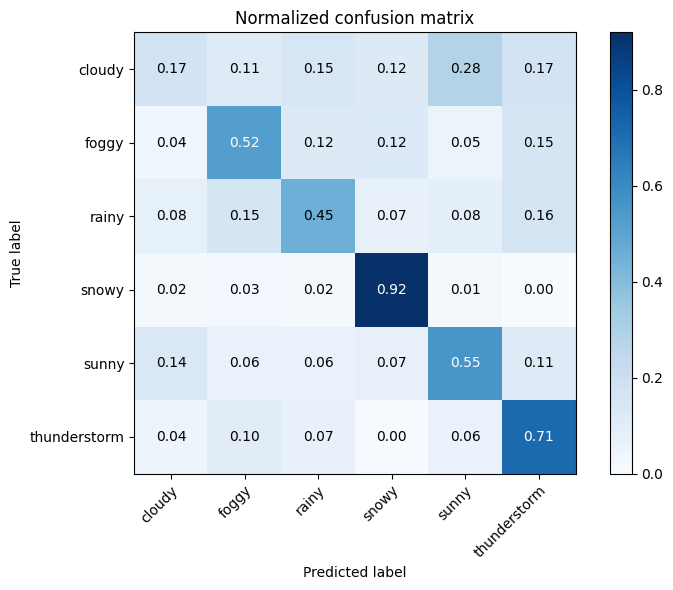

In [66]:
plot_confusion_matrix(predictions, normalize = True)

# Comparison with [OpenWeather](https://openweathermap.org/) forecasts


In [69]:
def handle_description(desc: str):
    weather_condition_lowered = desc.lower()

    if any(key in weather_condition_lowered for key in ['squall', 'thunderstorm']):
        desc = 'thunderstorm'
    elif any(key in weather_condition_lowered for key in ['drizzle', 'rain', "rainy"]):
        desc = 'rainy'
    elif any(key in weather_condition_lowered for key in ['sleet', 'snow', "snowy"]):
        desc = 'snowy'
    elif any(key in weather_condition_lowered for key in ['cloud', "overcast", "cloudy", "clouds"]):
        desc = 'cloudy'
    elif any(key in weather_condition_lowered for key in ['fog', 'mist', 'haze', "smoke", "dust", "foggy"]):
        desc = 'foggy'
    elif any(key in weather_condition_lowered for key in ['clear', 'sun', "sunny", ]):
        desc = 'sunny'
    return desc

def handle_append_data(json, humidity_arr, time_arr, wind_dir_arr, wind_speed_arr, pressure_arr, weather_desc_arr , temp_arr):
    try:
        for day_data in json["data"]["weather"]:

            date = day_data["date"]
            for hour_data in day_data['hourly']:
                time = "{date} {time}:00:00".format(date = date, time = int(int(hour_data["time"])/100))
                wind_speed_ms = round(float(hour_data["windspeedKmph"])* (10/36),2)
                wind_dir = int(hour_data["winddirDegree"])
                humidity = int(hour_data["humidity"])
                pressure = int(hour_data["pressure"])
                tempK = int(hour_data["tempC"]) + 273.15
                weather_desc = hour_data["weatherDesc"][0]["value"]
                weather_desc = handle_description(weather_desc)

                time_arr = np.append(time_arr, time)
                humidity_arr = np.append(humidity_arr ,  humidity)
                wind_speed_arr = np.append(wind_speed_arr, wind_speed_ms)
                wind_dir_arr = np.append(wind_dir_arr, wind_dir)
                pressure_arr = np.append(pressure_arr, pressure)
                temp_arr = np.append(temp_arr, tempK)
                weather_desc_arr = np.append(weather_desc_arr, weather_desc)

        return humidity_arr, time_arr, wind_dir_arr, wind_speed_arr, pressure_arr, weather_desc_arr , temp_arr
    except:
        print(json)

def get_7_days_forecasts_df(lng = 10.762622,lat = 106.660172, city_name = "Ho Chi Minh City", api_key = '5a88568c19234641b9075742242403'):
    link = "http://api.worldweatheronline.com/premium/v1/marine.ashx?q={lng},{lat}&key={api_key}&format=json&tp=3".format(
        lng = lng,
        lat = lat,
        api_key = api_key,
    )
    res = requests.get(link).json()

    humidity_arr = np.array([])
    time_arr = np.array([])
    wind_dir_arr = np.array([])
    wind_speed_arr = np.array([])
    pressure_arr = np.array([])
    temp_arr = np.array([])
    weather_desc_arr = np.array([], dtype = object)

    humidity_arr, time_arr, wind_dir_arr, wind_speed_arr, pressure_arr, weather_desc_arr , temp_arr = handle_append_data(
            res, humidity_arr, time_arr, wind_dir_arr, wind_speed_arr, pressure_arr, weather_desc_arr , temp_arr)
    df = ps.DataFrame({'datetime': time_arr, 'humidity': humidity_arr,'temperature': temp_arr,'pressure': pressure_arr,'wind_direction': wind_dir_arr,'wind_speed': wind_speed_arr,'weather_condition': weather_desc_arr,'city': city_name,'latitude':float(lat),'longitude':float(lng)})
    return df

In [70]:
worldweather_forecast = get_7_days_forecasts_df(49.24966, 123.119339, "Vancouver")

In [71]:
df_test = worldweather_forecast[numerical_cols + nominal_cols + [label_col]]

In [74]:
df_test = df_selected

In [75]:
openweather_forecasts_predictions = model.transform(df_test)

In [76]:
predictions = idx_to_str.transform(openweather_forecasts_predictions)

In [77]:
evaluate(predictions)

Accuracy: 0.5522826170919484
Precision: 0.5275880599316187
Recall: 0.5522826170919484
F1: 0.528918187852116


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


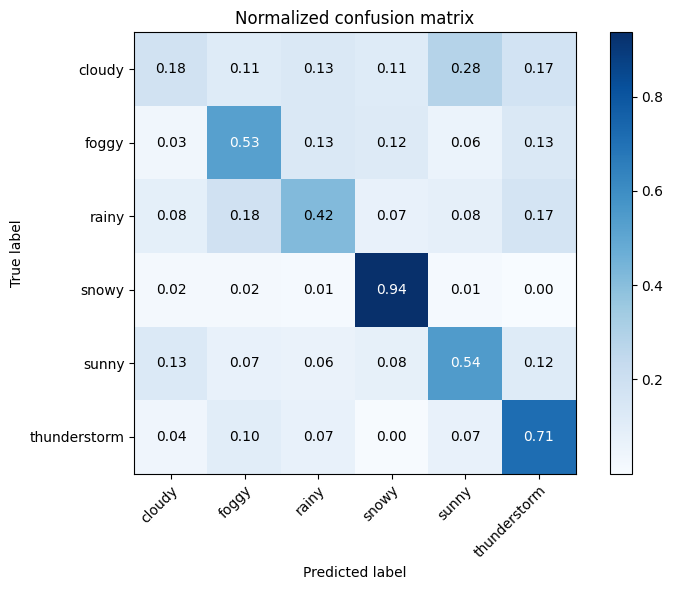

In [78]:
plot_confusion_matrix(predictions, normalize = True)